# Gradient Descent Debug

This notebook allows us to experiment with our different methods for computing gradient descent, and more easily debug their properties.

- In particular, we want to figure out why the "Modified Dan" method has such severe issues.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import math
import copy
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap

import helper

run_all_code = False # Runs code blocks below, one by one, with plots

Magnitude of f: 16.67


First, we generate data:

- The real data, using the real atmospheric forcing
- Fake data, using our noisy atmospheric forcing

In [2]:
nr,nc = 32,32
dt = 0.01
F = 0.1

#C_control is the covariance matrix of the full control vector f

C_control, x0, _, M = helper.generate_world(nr, nc, dt, F)

#C_known is the covariance matrix of the correct part of the control vector f
#C_error is the covariance matrix of the incorrect part of the control vector f

gamma = 2/3
C_known = C_control * gamma
C_error = C_control * (1-gamma)
C_ocean = C_control / 6

f_true, f_guess = helper.generate_true_and_first_guess_field(C_known, C_error, nr, nc)

In [3]:
# Atmosphere forcing coefficient
F = 0.1
# Standard deviation of the noise in the observations
sigma = 0.1 


# Number of timesteps to run the simulation for (repeated each iter)
num_timesteps = 4
# Number of iterations of gradient descent (repeated each run)
num_iters = 5
# Step size for gradient descent
step_size = 0.1

# Number of times to run the whole gradient descent optimization
num_runs = 1

# Run the simulation with the true and guessed control vector
saved_timesteps, real_state_over_time  = helper.compute_affine_time_evolution_simple(x0, M, F*f_true,  num_timesteps)
saved_timesteps, guess_state_over_time = helper.compute_affine_time_evolution_simple(x0, M, F*f_guess, num_timesteps)

Later, we'll need observations of the real ocean state:

In [4]:
num_obs_per_timestep = 50



observed_state_over_time_2d = helper.observe_over_time(real_state_over_time, sigma, 
                                                       num_obs_per_timestep, nr, nc)


observed_state_over_time =     [np.reshape(observed_state_2d, (nr*nc, 1)) 
                                for observed_state_2d in observed_state_over_time_2d]


# Visualizing debug variables

In the last notebook, we saw that the "Modified Dan" method had some very ugly behavior:

In [5]:
sim_dan_modified = True

if run_all_code or sim_dan_modified:

    weight_cov_term = 1e-6

    methods = [
        ["Simple Gradient Descent",       helper.simple_gradient_update_rule, []],
        ["Dan Gradient Descent",          helper.dan_update_rule, [C_error]],
        ["Dan Modified Gradient Descent", helper.dan_modified_update_rule, [C_error]],
    ]

    num_iters_local = 150
    step_size_local = step_size 
    losses, debug_vars = helper.compare_gd_methods_many_times(nr, nc, dt, F, gamma, sigma, num_obs_per_timestep, 
                                    num_timesteps, num_iters_local, step_size_local, 
                                    C_known, C_error, methods, num_runs, disp=True)

    

Run 1/1
  Method: Simple Gradient Descent
Running method Simple Gradient Descent
Iteration 0


c:\Users\ruizshau\Documents\GitHub\climate-sim\helper.py:1223: RuntimeWarning: invalid value encountered in scalar divide
  norm_dot_product = (f_adjust.T @ ui)[0,0] / (np.linalg.norm(f_adjust) * np.linalg.norm(ui))
c:\Users\ruizshau\Documents\GitHub\climate-sim\helper.py:1226: RuntimeWarning: invalid value encountered in scalar divide
  normalized_aiTs = (f_adjust.T @ s)[0,0] / (np.linalg.norm(f_adjust) * np.linalg.norm(s))
c:\Users\ruizshau\Documents\GitHub\climate-sim\helper.py:1227: RuntimeWarning: invalid value encountered in scalar divide
  normalized_Csdotai = (f_adjust.T @ (C_error @ s))[0,0] / (np.linalg.norm(f_adjust) * np.linalg.norm(C_error @ s))


Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
  Method: Dan Gradient Descent
Running method Dan Gradient Descent
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
  Method: Dan Modified Gradient Descent
Running method Dan Modified Gradient Descent
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140


In [6]:
view_dan_modified = False

if run_all_code or (sim_dan_modified and view_dan_modified):
    helper.plot_losses(losses, num_obs_per_timestep, step_size_local, num_timesteps, num_iters_local)

We want to figure out why. So, we'll invoke the debugging variables we created in the last notebook, and see if we can't figure out what's going on:

In [7]:
def plot_debug(debug_vars, min_iter=None, max_iter=None, tickwidth=1, vlines = []):
    """
    Plot 9 chosen debug variables in a 3x3 grid for each method.

    Args:
    debug_vars (dict): Dictionary containing debug variables for each method
    min_iter (int, optional): Start index for plotting. If None, starts from the beginning.
    max_iter (int, optional): End index for plotting. If None, plots until the end.
    tickwidth (int): Width between ticks on x-axis
    vlines (list): List of vertical lines to add to the plot

    Returns:
    None: Displays the plot
    """
    # Determine the actual range of iterations
    all_iters = next(iter(debug_vars.values()))["Norm of s_i"]
    total_iters = len(all_iters)

    # Set min_iter and max_iter if they are None
    min_iter = 0 if min_iter is None else max(0, min_iter)
    max_iter = total_iters if max_iter is None else min(total_iters, max_iter)

    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle(f"Debug Variables: Iterations {min_iter} to {max_iter}")

    # List of debug variables to plot
    plot_vars = [
        "Norm of s_i",
        "Expected Delta J w simple gd",
        "Expected Delta J w update rule",
        "Actual Delta J",
        "Norm of simple gd ui",
        "Norm of update rule ui",
        "Normalized dot product $a_i$ and $u_i$",
        "Normalized $-Cs_i \cdot a_i$",
        "Norm of $a_i$",
    ]

    for i, (var_name, ax) in enumerate(zip(plot_vars, axs.flatten())):
        for method_name, method_debug_vars in debug_vars.items():
            if var_name in method_debug_vars:
                plot_data = method_debug_vars[var_name][min_iter:max_iter]
                ax.plot(range(min_iter, max_iter), plot_data, ".-", label=method_name)
        
        ax.set_xlabel("Iteration $i$")
        ax.set_ylabel(var_name)
        ax.legend()
        ax.set_title(var_name)
        ax.grid(True)
        
        # Set x-axis ticks to reflect the actual iteration numbers
        ticks = range(min_iter, max_iter, tickwidth)
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks)

        # Add vertical lines if specified
        for vline in vlines:
            if min_iter <= vline < max_iter:
                ax.axvline(x=vline, color='r', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

In [8]:
# Plot debug variables

debug_danmod_view = True

if run_all_code or (sim_dan_modified and debug_danmod_view):
    k1 = 82-3
    k2 = 98+3
    tickwidth = 5
    a_is = debug_vars["Dan Gradient Descent"]["$a_i$"]
    a_i = a_is[-1]

    print(np.linalg.norm(a_i))
    print()

    #Retrieve the final a_i, compute the covariance using it


    

14.36066367469391



A few observations:

- Before things get bad, the dot product between $a_i$ and $u_i$ begins to diverge.
- The difference between the expected and true $\Delta J$ spikes strongly.
    - This is likely because the norm of $u_i$ becomes large, and therefore, our local linearity assumption that $dJ/df \approx \Delta J/\Delta f$ doesn't hold.

# PCA Analysis

One problem with trying to understand what our gradient descent does, is that it's happening in a very high-dimensional space: we can't effectively visualize it.

- We'll use PCA to reduce our data into a lower-dimensional space.

- That way, we can visualize the trajectory of ```f_adjust``` after each iteration.

## Variance Explained

First, we need to check: how much of our data is presented by each PCA component? If say, 10 components are important, and if we use a 2D plot, we'll miss a lot of data in our reduced visualization. 

- We measure the "importance" of each component by the amount of variance it can explain.

In [9]:
def perform_pca_analysis(debug_vars, method_label, target_variance=0.95):
    """
    Perform PCA analysis on the $a_i$ vectors from the debug variables.

    Args:
    debug_vars (dict): Dictionary containing debug variables for each method
    method_label (str): Label of the method to analyze
    target_variance (float): Target explained variance (default: 0.95)

    Returns:
    None: Displays plots and prints analysis results
    """
    # Extract and reshape data
    vector_list = debug_vars[method_label]["$a_i$"]
    data = np.array(vector_list)
    data_reshaped = data.reshape(data.shape[0], -1)

    # Perform PCA
    pca = PCA()
    pca.fit(data_reshaped)

    # Calculate variance ratios
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    # Plot explained variance ratio
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title(f'Explained Variance Ratio by Principal Component ({method_label})')
    plt.show()

    # Plot cumulative explained variance ratio
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title(f'Cumulative Explained Variance Ratio ({method_label})')
    plt.grid(True)
    plt.show()

    # Determine number of components for target variance
    n_components = np.argmax(cumulative_variance_ratio >= target_variance) + 1
    print(f"Number of components needed to explain {target_variance*100}% of variance: {n_components}")

    # Print magnitude of each component
    for i, ratio in enumerate(explained_variance_ratio[:10]):  # Print first 10 components
        print(f"Component {i+1}: {ratio:.4f}")

In [10]:
pca_variance_explained_view = False

if run_all_code or (sim_dan_modified and pca_variance_explained_view):
    perform_pca_analysis(debug_vars, "Dan Modified Gradient Descent", target_variance=0.95)

## Visualizing with PCA

We can explain >95% of the variance with only two components: by looking at a 2D PCA plot, we should be able to understand most of what's happening.

In [11]:
def visualize_pca_results(debug_vars, method_label, min_iter=None, max_iter=None):
    """
    Visualize the first two principal components of the $a_i$ vectors for a single method.

    Args:
    debug_vars (dict): Dictionary containing debug variables for each method
    method_label (str): Label of the method to visualize
    min_iter (int, optional): Minimum iteration number to include
    max_iter (int, optional): Maximum iteration number to include

    Returns:
    None: Displays the plot
    """
    # Prepare the data
    data = np.array(debug_vars[method_label]["$a_i$"])

    print(data.shape)
    
    # Apply iteration range if specified
    if min_iter is not None or max_iter is not None:
        min_idx = min_iter if min_iter is not None else 0
        max_idx = max_iter if max_iter is not None else data.shape[0]
        data = data[min_idx:max_idx]
    
    data_reshaped = data.reshape(data.shape[0], -1)

    # Perform PCA and transform the data
    pca = PCA(n_components=2)
    a_i_compressed = pca.fit_transform(data_reshaped)

    # Create a custom colormap
    colors = ['blue', 'green', 'yellow', 'red']
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=100)

    # Plot the compressed data
    plt.figure(figsize=(12, 8))

    for i in range(len(a_i_compressed) - 1):
        plt.plot(a_i_compressed[i:i+2, 0], a_i_compressed[i:i+2, 1], 
                 color=cmap(i / (len(a_i_compressed) - 1)), 
                 linewidth=2)

    scatter = plt.scatter(a_i_compressed[:, 0], a_i_compressed[:, 1], 
                          c=range(len(a_i_compressed)), cmap=cmap, 
                          s=50, zorder=10)

    plt.colorbar(scatter, label='Iterations')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    title = f'$a_i$ Terms Compressed to First Two Principal Components ({method_label})'
    if min_iter is not None or max_iter is not None:
        title += f'\nIterations {min_iter or 0} to {max_iter or "end"}'
    plt.title(title)
    plt.grid(True)

    # Annotate start and end points
    plt.annotate('Start', (a_i_compressed[0, 0], a_i_compressed[0, 1]), 
                 xytext=(5, 5), textcoords='offset points')
    plt.annotate('End', (a_i_compressed[-1, 0], a_i_compressed[-1, 1]), 
                 xytext=(5, 5), textcoords='offset points')

    plt.tight_layout()
    plt.show()

    # Print the explained variance ratio
    print(f"Explained variance ratio of the first two components: {pca.explained_variance_ratio_}")



In [12]:
debug_danmod_pca = False

# Usage example:
if run_all_code or (sim_dan_modified and debug_danmod_pca):
    visualize_pca_results(debug_vars, "Dan Modified Gradient Descent")

This visualization is interesting: it seems that our plot starts out smoothly optimizing, as we see in our loss plot. It almost entirely follows basically the same direction.

- But abruptly, it jumps back near where it started, very chaotically.
- In fact, it does so several times, after making more progress each time.

## 1D PCA

This gets pretty messy to look at. So, we can focus on one dimension at a time, to make it easier to visualize.

In [13]:
def visualize_pca_nth_component_value(debug_vars, method_label, n_component=1, min_iter=None, max_iter=None):
    """
    Visualize the value of the nth principal component of the $a_i$ vectors over iterations.

    Args:
    debug_vars (dict): Dictionary containing debug variables for each method
    method_label (str): Label of the method to visualize
    n_component (int): The nth component to visualize (1-indexed, default is 1)
    min_iter (int, optional): Minimum iteration number to include
    max_iter (int, optional): Maximum iteration number to include

    Returns:
    None: Displays the plot
    """
    # Prepare the data
    data = np.array(debug_vars[method_label]["$a_i$"])
    
    # Apply iteration range if specified
    if min_iter is not None or max_iter is not None:
        min_idx = min_iter if min_iter is not None else 0
        max_idx = max_iter if max_iter is not None else data.shape[0]
        data = data[min_idx:max_idx]
    else:
        min_idx = 0
    
    data_reshaped = data.reshape(data.shape[0], -1)

    # Perform PCA
    pca = PCA(n_components=n_component)
    a_i_compressed = pca.fit_transform(data_reshaped)

    # Create iteration array
    iterations = np.arange(len(a_i_compressed)) + min_idx

    # Plot the nth component value
    plt.figure(figsize=(12, 6))
    plt.plot(iterations, a_i_compressed[:, n_component-1], '-o', markersize=4)
    
    plt.xlabel('Iterations')
    plt.ylabel(f'{n_component}{"st" if n_component == 1 else "nd" if n_component == 2 else "th"} Principal Component Value')
    title = f'{n_component}{"st" if n_component == 1 else "nd" if n_component == 2 else "th"} Principal Component Value Over Iterations ({method_label})'
    if min_iter is not None or max_iter is not None:
        title += f'\nIterations {min_iter or 0} to {max_iter or "end"}'
    plt.title(title)
    plt.grid(True)

    # Add horizontal line at y=0 for reference
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Print the explained variance ratio
    print(f"Explained variance ratio of the {n_component}{'st' if n_component == 1 else 'nd' if n_component == 2 else 'th'} component: {pca.explained_variance_ratio_[-1]:.4f}")



In [14]:
view_1d_pca = False

if run_all_code or (sim_dan_modified and view_1d_pca):
    visualize_pca_nth_component_value(debug_vars, 'Dan Modified Gradient Descent', n_component=1)
    visualize_pca_nth_component_value(debug_vars, 'Dan Modified Gradient Descent', n_component=2)

This matches our above observation: each time it fails, it hops back and forth perpendicular to the line, before stabilizing near where it started. 

- As we iterate further, it converges on a point roughly in the center, even though we know it can find a lower loss elsewhere.

## Plot Each Method

Maybe the "Dan Modified Method" is breaking because it's exploring a different region of the space than Dan or regular Gradient Descent? 

- Let's plot the control adjustments over time for all three.

In [15]:
def visualize_pca_results_multi_method(debug_vars, method_labels, min_iter=None, max_iter=None):
    """
    Visualize the first two principal components of the $a_i$ vectors across multiple methods.

    Args:
    debug_vars (dict): Dictionary containing debug variables for each method
    method_labels (list): List of method labels to include in the visualization
    min_iter (int, optional): Minimum iteration number to include
    max_iter (int, optional): Maximum iteration number to include

    Returns:
    None: Displays the plot
    """
    # Prepare the data
    all_data = []
    for label in method_labels:
        data = np.array(debug_vars[label]["$a_i$"])
        if min_iter is not None or max_iter is not None:
            min_idx = min_iter if min_iter is not None else 0
            max_idx = max_iter if max_iter is not None else data.shape[0]
            data = data[min_idx:max_idx]
        all_data.append(data.reshape(data.shape[0], -1))
    
    all_data_combined = np.vstack(all_data)

    # Perform PCA on combined data
    pca = PCA(n_components=2)
    all_data_compressed = pca.fit_transform(all_data_combined)

    # Plot setup
    plt.figure(figsize=(12, 8))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(method_labels)))
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'H']  # Add more if needed

    start_idx = 0
    for i, label in enumerate(method_labels):
        data = np.array(debug_vars[label]["$a_i$"])
        if min_iter is not None or max_iter is not None:
            min_idx = min_iter if min_iter is not None else 0
            max_idx = max_iter if max_iter is not None else data.shape[0]
            data = data[min_idx:max_idx]
        end_idx = start_idx + data.shape[0]
        method_data = all_data_compressed[start_idx:end_idx]

        # Plot trajectory
        plt.plot(method_data[:, 0], method_data[:, 1], 
                 color=colors[i], marker=markers[i], linestyle='-', 
                 markersize=5, label=label)

        # Annotate start and end points
        plt.annotate('Start', (method_data[0, 0], method_data[0, 1]), 
                     xytext=(5, 5), textcoords='offset points', color=colors[i])
        plt.annotate('End', (method_data[-1, 0], method_data[-1, 1]), 
                     xytext=(5, 5), textcoords='offset points', color=colors[i])

        start_idx = end_idx

    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    title = '$a_i$ Terms Compressed to First Two Principal Components (All Methods)'
    if min_iter is not None or max_iter is not None:
        title += f'\nIterations {min_iter or 0} to {max_iter or "end"}'
    plt.title(title)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print the explained variance ratio
    print(f"Explained variance ratio of the first two components: {pca.explained_variance_ratio_}")



In [16]:
view_all_pca = False

if run_all_code or (sim_dan_modified and view_all_pca):
    method_labels = ["Simple Gradient Descent", "Dan Gradient Descent", "Dan Modified Gradient Descent"]
    visualize_pca_results_multi_method(debug_vars, method_labels)

The results we get are as we might expect based on the loss plot: the Dan method and the Dan modified methods have very similar adjustments when the latter fails.

- The simple gradient descent method does explore a distinct region of space.

# Switching Gradient Descent Methods

## Switching from Dan to Dan Modified

Well, Dan and Dan-Modified seem to be exploring *similar* regions of space, but "similar" is vague. 

Here's a way we could clear things up: what if we placed the Dan method at the *exact* position where Dan-Modified breaks? 

- We'll implement this by creating a gradient descent method that swaps methods at a particular index.

In [17]:
# Depending on the random setup of our problem, the exact iteration that Dan Modified breaks on, will change.
# So, you may have to adjust break_iter.

break_iter = 83
    
def create_switch_gradient_descent(break_iter, duration, 
                              method_1, method_2):

    switch_iters = [ i + break_iter for i in range(duration)]

    def switch_update_rule(curr_iter, s, step_size, f_adjust, *extra_params):
        """Use method_1 by default, and use method_2 during any iter included in switch_iters """
        if curr_iter in switch_iters: 
            return method_2(curr_iter, s, step_size, f_adjust, *extra_params)
        else:
            return method_1(curr_iter, s, step_size, f_adjust, *extra_params)
    
    def switch_gradient_descent(M, F, f_true, f_guess, C_known, C_error,       # World parameters
                                x0, timesteps,                                   # Simulation parameters
                                ocean_states_observed, num_iters, step_size,      # Optimization parameters
                                disp=False):                                      # Optimization method
        return helper.gradient_descent_template(M, F, f_true, f_guess, C_known, C_error, 
                                        x0, timesteps, 
                                        ocean_states_observed, num_iters, step_size,
                                        switch_update_rule, [C_error], disp)
    
    return switch_gradient_descent

def create_dan_switch_gradient_descent(break_iter, duration):
    return create_switch_gradient_descent(break_iter, duration,
                                          helper.dan_modified_update_rule, helper.dan_update_rule)
    


We'll consider multiple variants, where we spend multiple iterations running the dan_method instead of dan_modified.

- This will allow us to see if running dan_method long enough allows us to "avoid" the bug we're worried about.

In [18]:
num_iters_local = 100
gradient_descent_funcs = {
    "dan_modified": helper.dan_modified_gradient_descent,
    "dan_switch_gradient_descent1": create_dan_switch_gradient_descent(break_iter, 1),
    "dan_switch_gradient_descent2": create_dan_switch_gradient_descent(break_iter, 2),
    "dan_switch_gradient_descent4": create_dan_switch_gradient_descent(break_iter, 4),
    "dan_switch_gradient_descent8": create_dan_switch_gradient_descent(break_iter, 8),
    "dan_switch_gradient_descent16": create_dan_switch_gradient_descent(break_iter, 16),
}

In [19]:
danmod_to_dan_run = True

if run_all_code or danmod_to_dan_run:

    losses = {
    }
    debug_vars = {
    }

    #Iterate over gradient_descent_funcs

    for name, gradient_descent_func in gradient_descent_funcs.items():
        _, loss, debug = gradient_descent_func(M, F, f_true, f_guess, C_control, C_error,
                                        x0, num_timesteps, observed_state_over_time, 
                                        num_iters_local, step_size,
                                        disp=True) 
        
        losses[name] = loss
        debug_vars[name] = debug







Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90


In [20]:
danmod_to_dan_run_plot = False

if run_all_code or (danmod_to_dan_run and danmod_to_dan_run_plot):

    helper.plot_losses(losses, num_obs_per_timestep, step_size, num_timesteps, num_iters_local, min_iter=80, max_iter=100)

In [21]:
danmod_to_dan_run_debug = False

if run_all_code or (danmod_to_dan_run and danmod_to_dan_run_debug):
    k1 = 80
    k2 = 90
    tickwidth = 5
    plot_debug(debug_vars, k1, k2, tickwidth)

    



This is notable: this shows that 1. using the dan method does prevent the bug, 2. switching back to the dan_modified method seems to cause it to break again, even if we wait a while.

## Switching from Dan Modified to Dan

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90


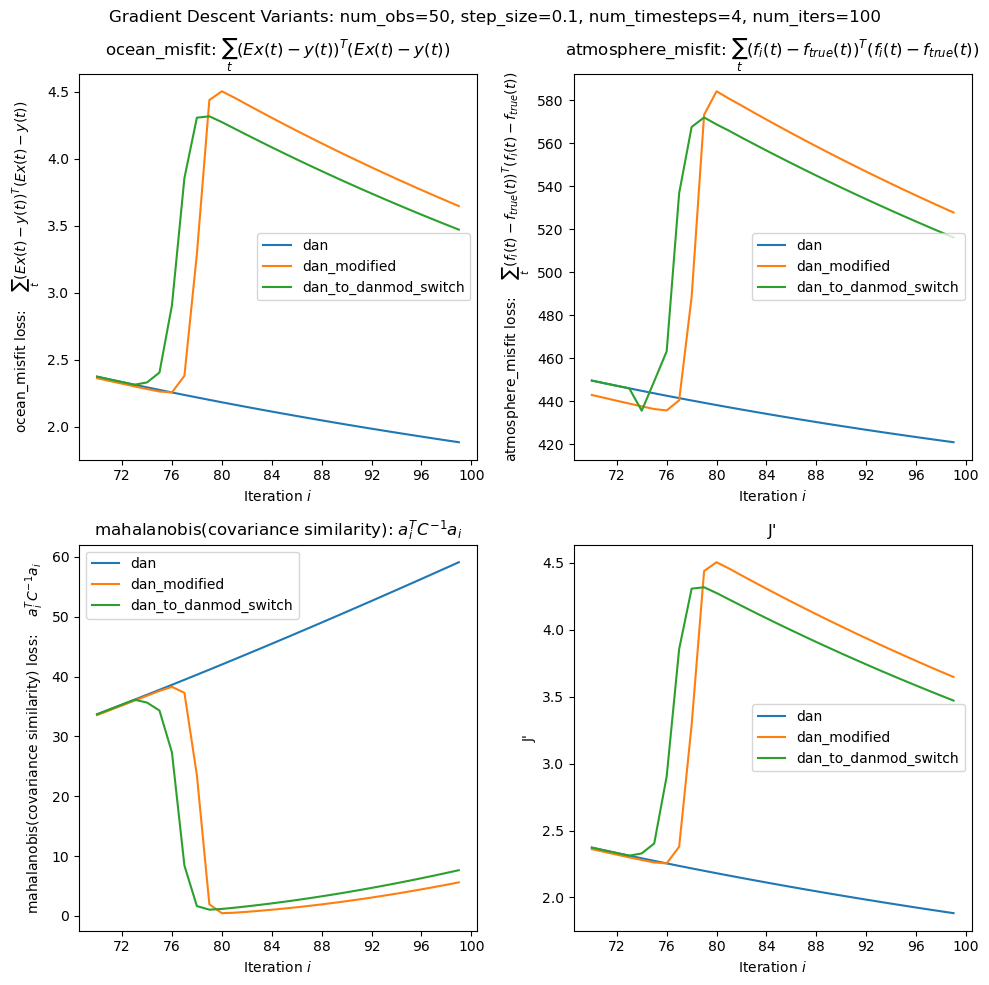

In [22]:
def create_dan_to_danmod_switch_gradient_descent(break_iter):
    return create_switch_gradient_descent(break_iter, num_iters_local - break_iter,
                                          helper.dan_update_rule, helper.dan_modified_update_rule)

new_break_iter = break_iter-10

gradient_descent_funcs = {
    "dan": helper.dan_gradient_descent,
    "dan_modified": helper.dan_modified_gradient_descent,
    "dan_to_danmod_switch": create_dan_to_danmod_switch_gradient_descent(new_break_iter),
}

dan_to_danmod_run = True

if run_all_code or dan_to_danmod_run:
    losses = {}
    debug_vars = {}

    for name, gradient_descent_func in gradient_descent_funcs.items():
        _, loss, debug = gradient_descent_func(M, F, f_true, f_guess, C_control, C_error,
                                        x0, num_timesteps, observed_state_over_time, 
                                        num_iters_local, step_size,
                                        disp=True) 
        
        losses[name] = loss
        debug_vars[name] = debug

# Plotting the results
dan_to_danmod_run_plot = True

if run_all_code or (dan_to_danmod_run and dan_to_danmod_run_plot):
    helper.plot_losses(losses, num_obs_per_timestep, step_size, num_timesteps, num_iters_local, min_iter=70)


Swithing to Dan Modified from the default Dan approach immediately caused an initial crash: this really does seem to reinforce that "Dan Modified" is the problem.

- We can also note that in our previous plots of ```debug_vars```, we can see that $a_i$ and $Cs$ have a smaller normalized dot product in the Dan method.
- This means that they are moving in more significantly different directions. 
- This would explain why **switching** to Dan Modified breaks sooner than starting with Dan Modified normally: Dan Modified usually keeps $a_i$ and $Cs$ similar, so this problem takes longer to occur.

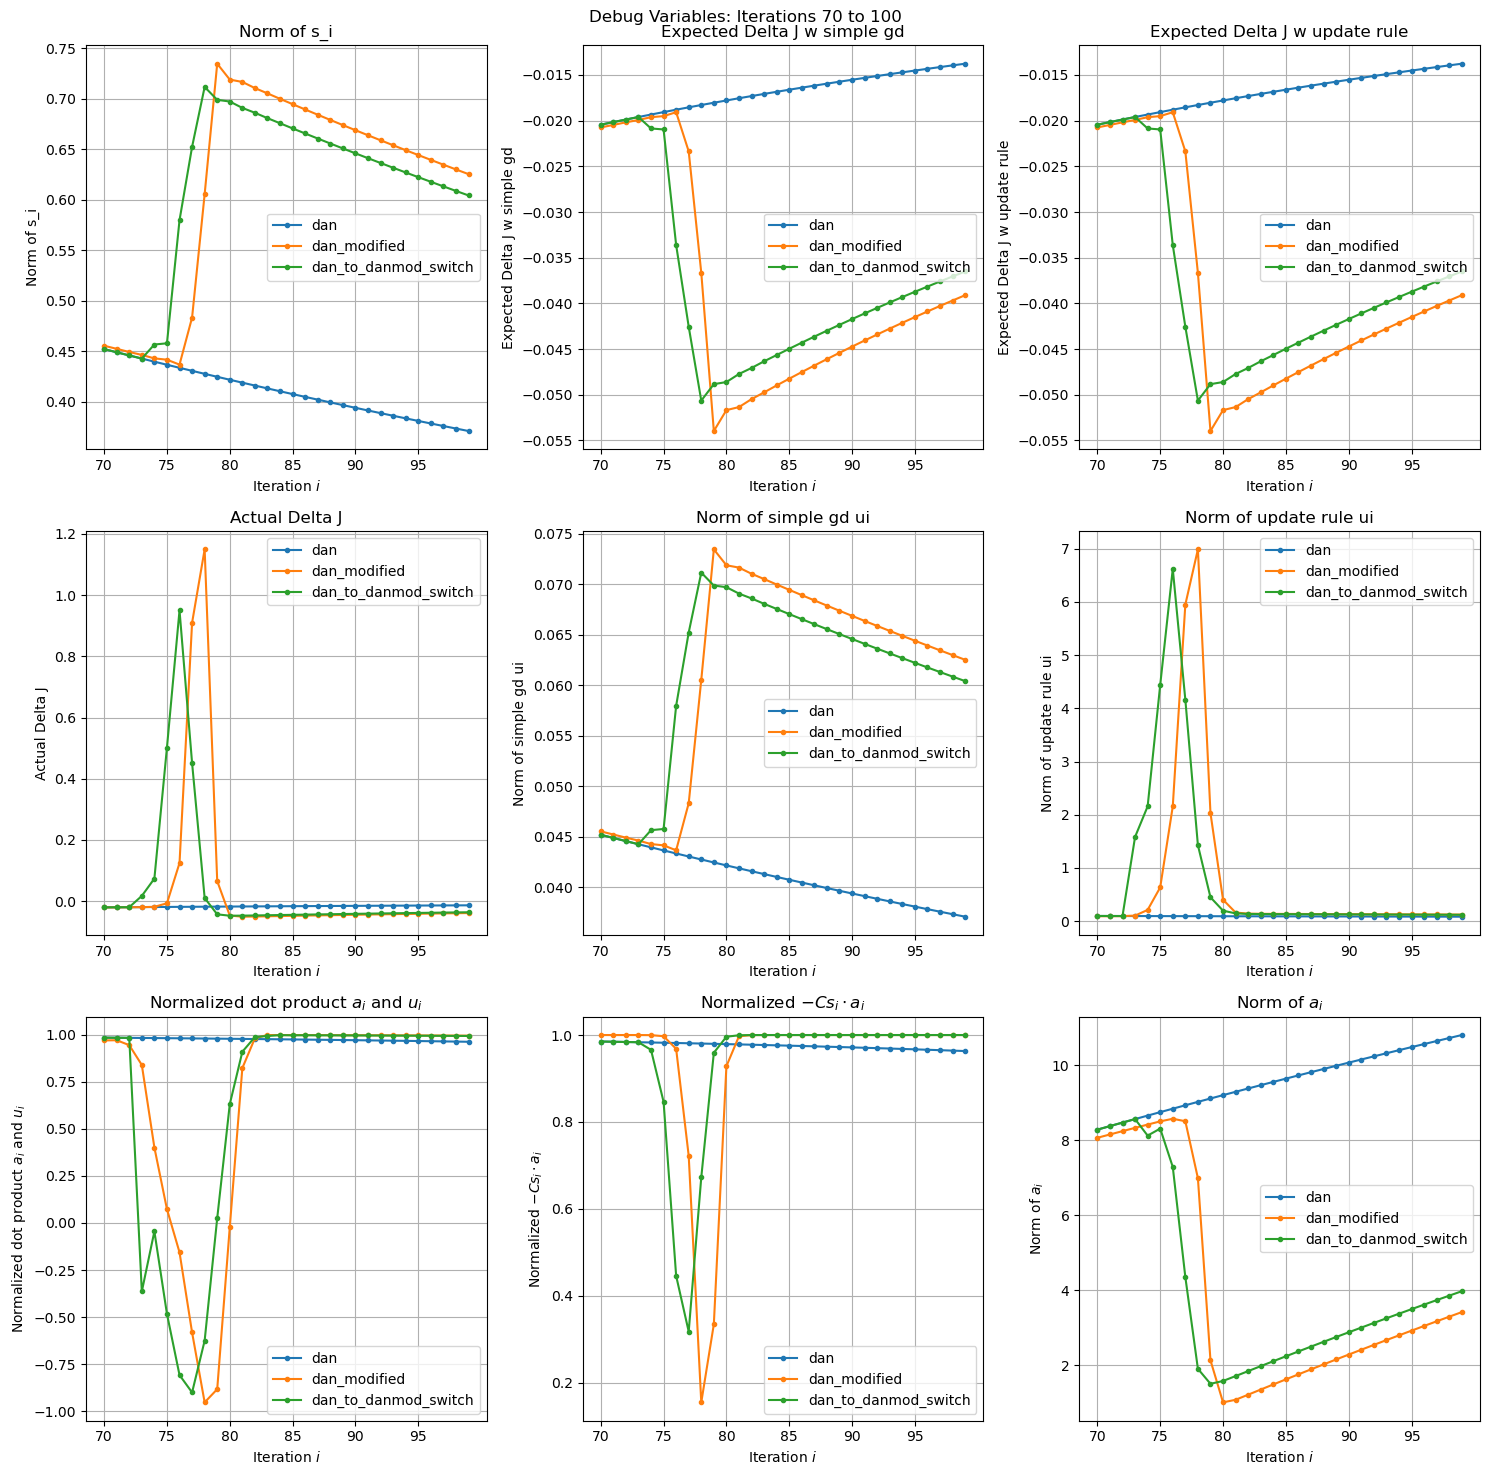

In [23]:
# Plotting the debug variables
dan_to_danmod_run_debug = True

if run_all_code or (dan_to_danmod_run and dan_to_danmod_run_debug):
    k1 = 70
    k2 = 150
    tickwidth = 5
    plot_debug(debug_vars, k1, k2, tickwidth)

    